In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

colors = {
    "Word2Vec": "#C50093",
    "fastText": "#F32E77",
    "SBERT": "#FF645E",
    "feature_synthesis": "#FF984C",
    "TF-IDF": "#FFCA4F",
    "search": "#F9F871",
}

import matplotlib

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Computer Modern"]

In [2]:
def barplotter(df, xcol, xlabel, ycol, ylabel):

    sorted = df.sort_values(ycol, ascending=False)

    x_colours = [colors[x] for x in sorted[xcol]]

    ax = sns.barplot(sorted, x=xcol, y=ycol, palette=x_colours)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.tick_params(rotation=30)

    for bar in ax.patches:
        height = bar.get_height()

        ax.text(
            x=bar.get_x() + (bar.get_width() / 2),
            y=height * 1.01,
            s=f"{height:.5g}",
            ha="center",
        )

    plt.figure(figsize=(20, 10))
    plt.show()

# Precision and NDCG

In [3]:
labelled_df = pd.read_excel("./data/evaluation_data_final.xlsx")

Compute precision, using recipes labelled as good as "true positive" and assuming all recommendations are considered a positive label:

In [4]:
precision = labelled_df.groupby("Rec_System")["Good"].agg("mean").sort_values()

In [5]:
import math

# group by recommendation system and origin ID


def recommendation_set_dcg(labels):

    rankings = [
        label / math.log(index + 1.0, 2) for index, label in enumerate(labels, 1)
    ]

    total = sum(rankings)

    idcg = sum([1.0 / math.log(i + 1.0, 2) for i in range(1, len(labels) + 1)])

    return total / idcg


def aggregator(series):

    return [series]

In [6]:
ndcg = labelled_df.groupby(["Rec_System", "Origin_Id"])["Good"].agg(aggregator)

df = ndcg.to_frame()

In [7]:
labelled_df.columns

Index(['Column1', 'Good', 'Rec_Name', 'Rec_Description', 'Rec_Ingredients',
       'Rec_System', 'Recommendation_Id', 'Rank', 'Origin_Name',
       'Origin_Description', 'Origin_Ingredients', 'Origin_Id'],
      dtype='object')

In [8]:
pivot = labelled_df.pivot(
    index=["Rec_System", "Recommendation_Id", "Origin_Id"],
    columns="Rank",
    values="Good",
)
pivot = pivot.groupby(["Rec_System", "Origin_Id"]).agg("max")

In [9]:
pivot

Rank                    0    1    2    3    4    5    6    7    8    9
Rec_System Origin_Id                                                  
SBERT      2704       1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0
           34431      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
           55025      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
           67166      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
           87667      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
search     455125     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
           459476     1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
           461727     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
           505623     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
           505798     1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

[150 rows x 10 columns]

In [10]:
pivot["ndcg"] = pivot.apply(lambda row: recommendation_set_dcg(row.tolist()), axis=1)

In [11]:
ndcg = pivot.groupby("Rec_System").agg("mean")["ndcg"]

In [12]:
metrics = ndcg.to_frame()

metrics["precision"] = precision
metrics = metrics.reset_index()

In [13]:
metrics

,Rec_System,ndcg,precision
0,SBERT,0.407965,0.381526
1,TF-IDF,0.372413,0.348000
2,Word2Vec,0.645113,0.620000
3,fastText,0.431094,0.384000
4,feature_synthesis,0.065947,0.060000
5,search,0.294915,0.253012


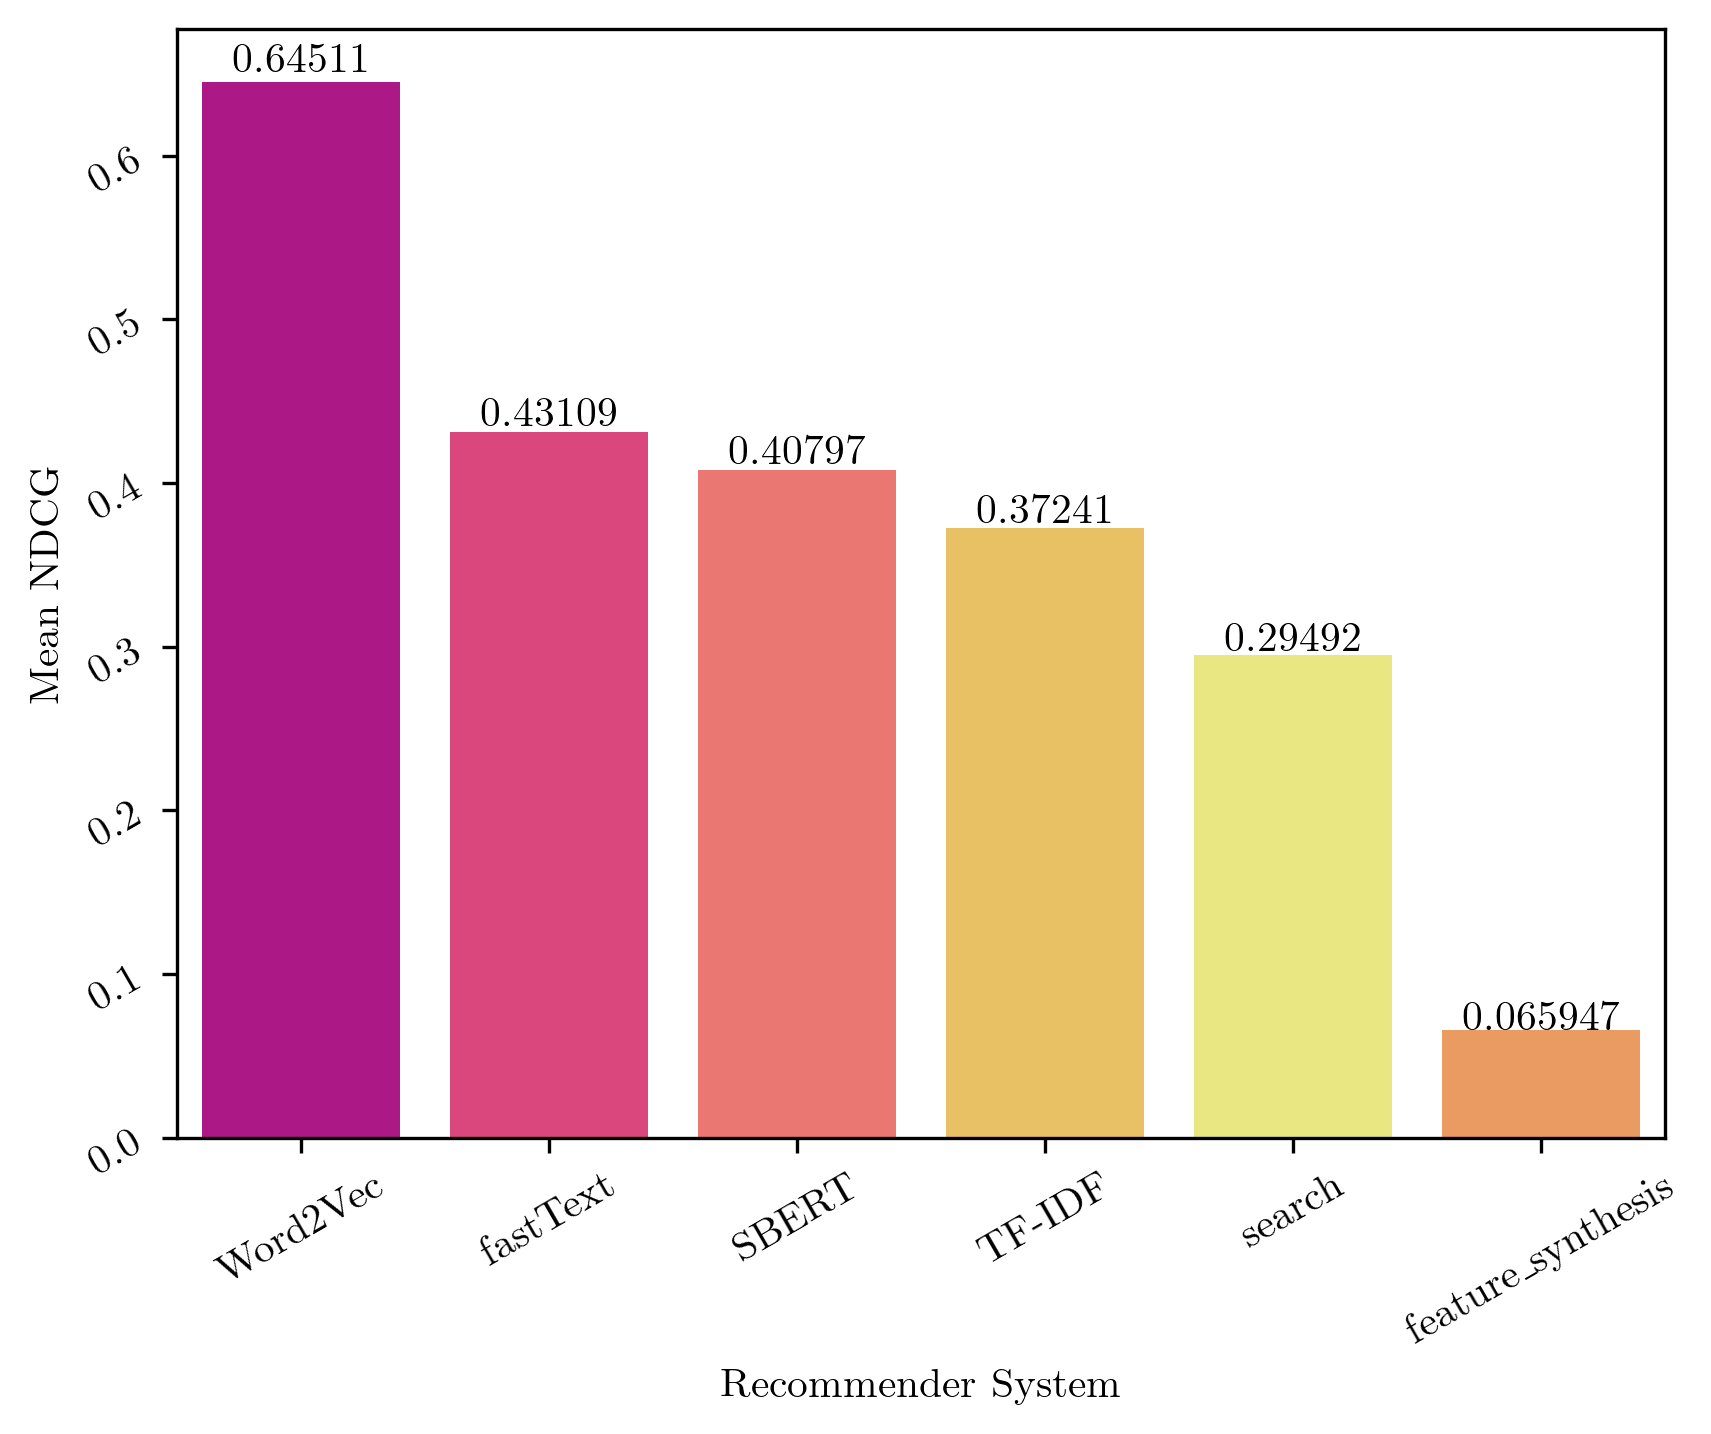

<Figure size 6000x3000 with 0 Axes>

In [14]:
barplotter(metrics, "Rec_System", "Recommender System", "ndcg", "Mean NDCG")

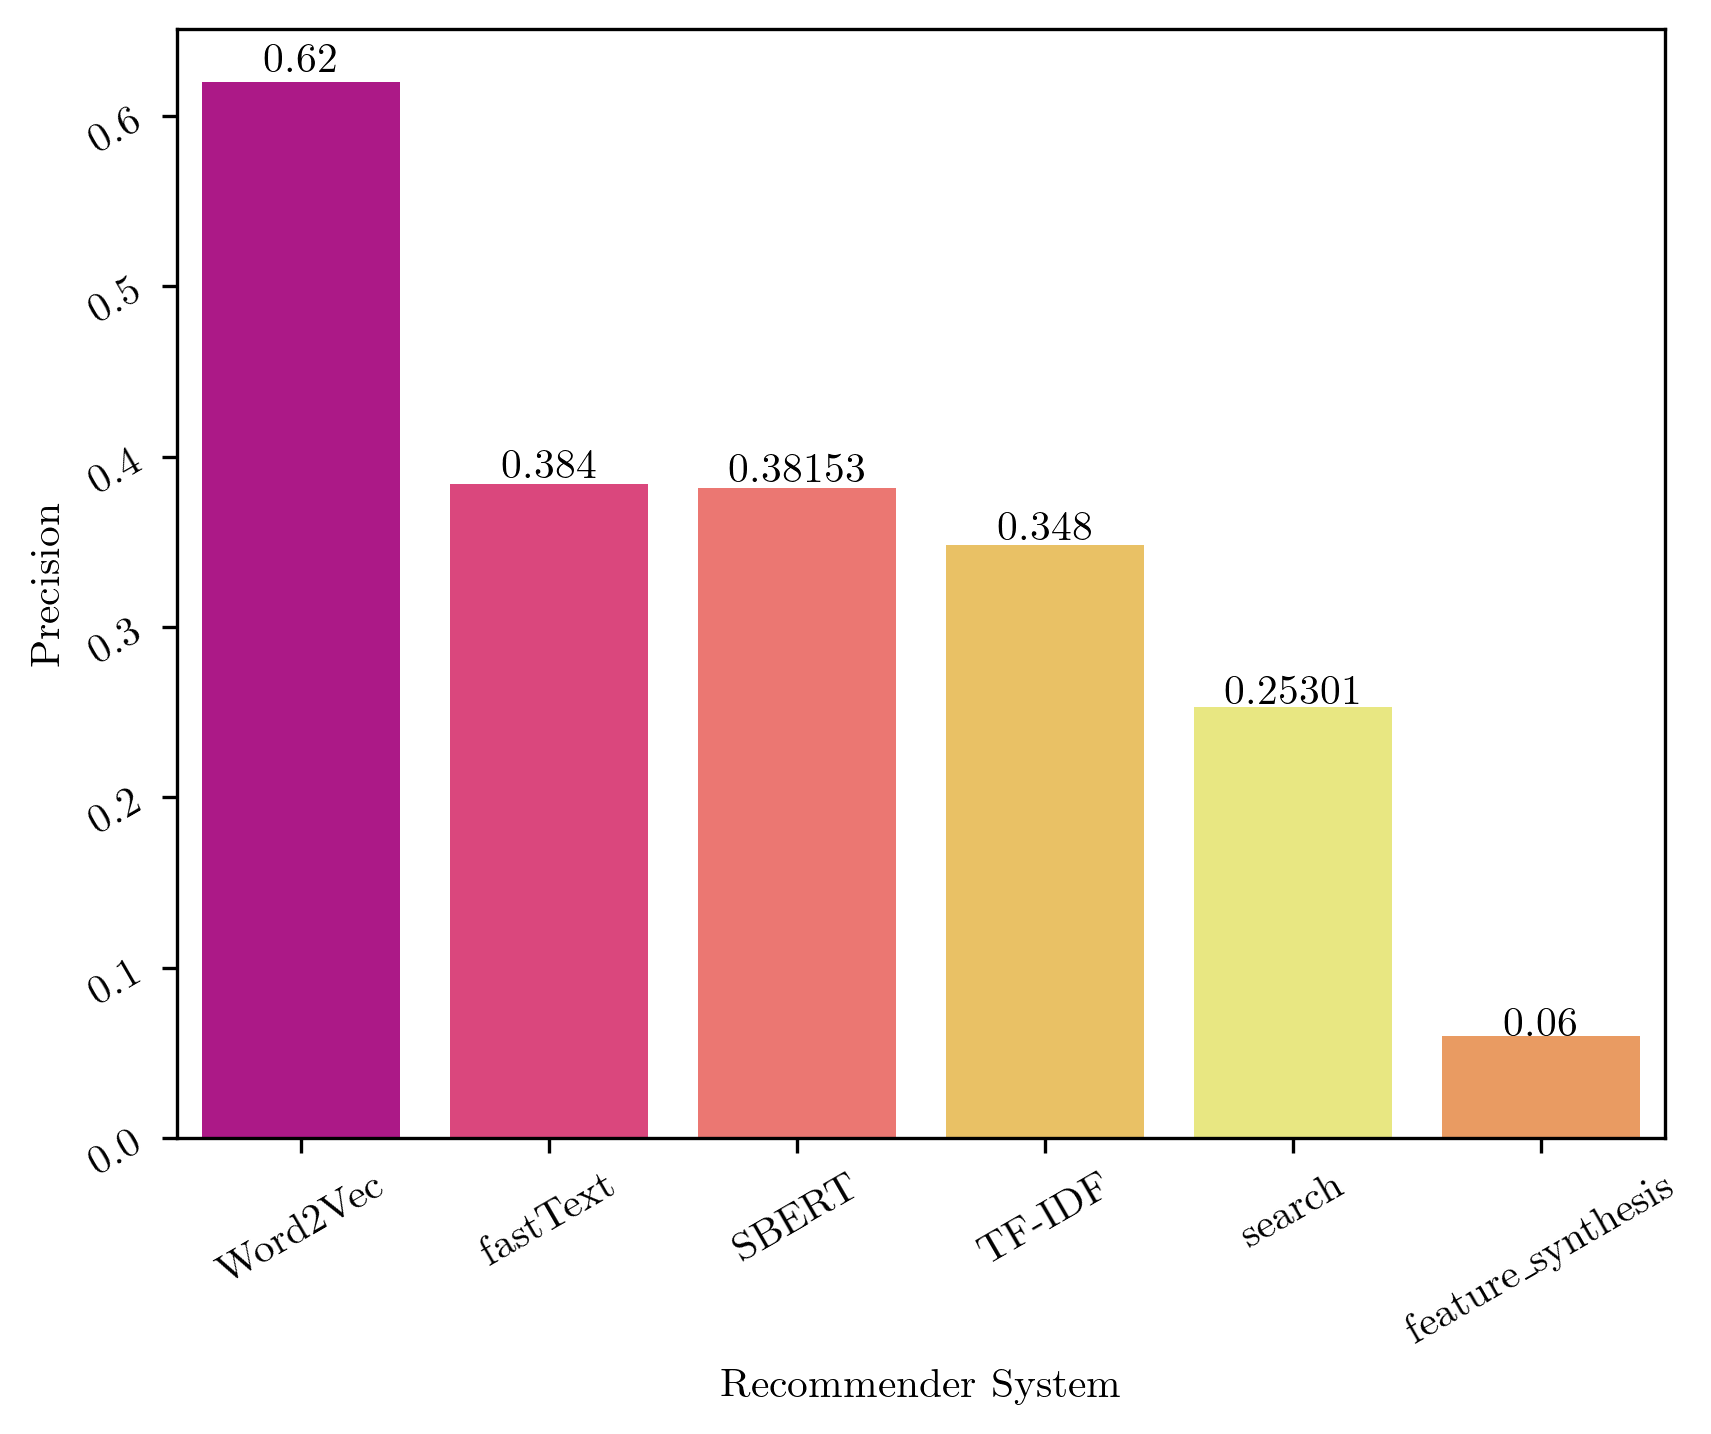

<Figure size 6000x3000 with 0 Axes>

In [15]:
barplotter(metrics, "Rec_System", "Recommender System", "precision", "Precision")

In [16]:
metrics.melt("Rec_System")

,Rec_System,variable,value
0,SBERT,ndcg,0.407965
1,TF-IDF,ndcg,0.372413
2,Word2Vec,ndcg,0.645113
3,fastText,ndcg,0.431094
4,feature_synthesis,ndcg,0.065947
5,search,ndcg,0.294915
6,SBERT,precision,0.381526
7,TF-IDF,precision,0.348000
8,Word2Vec,precision,0.620000
9,fastText,precision,0.384000


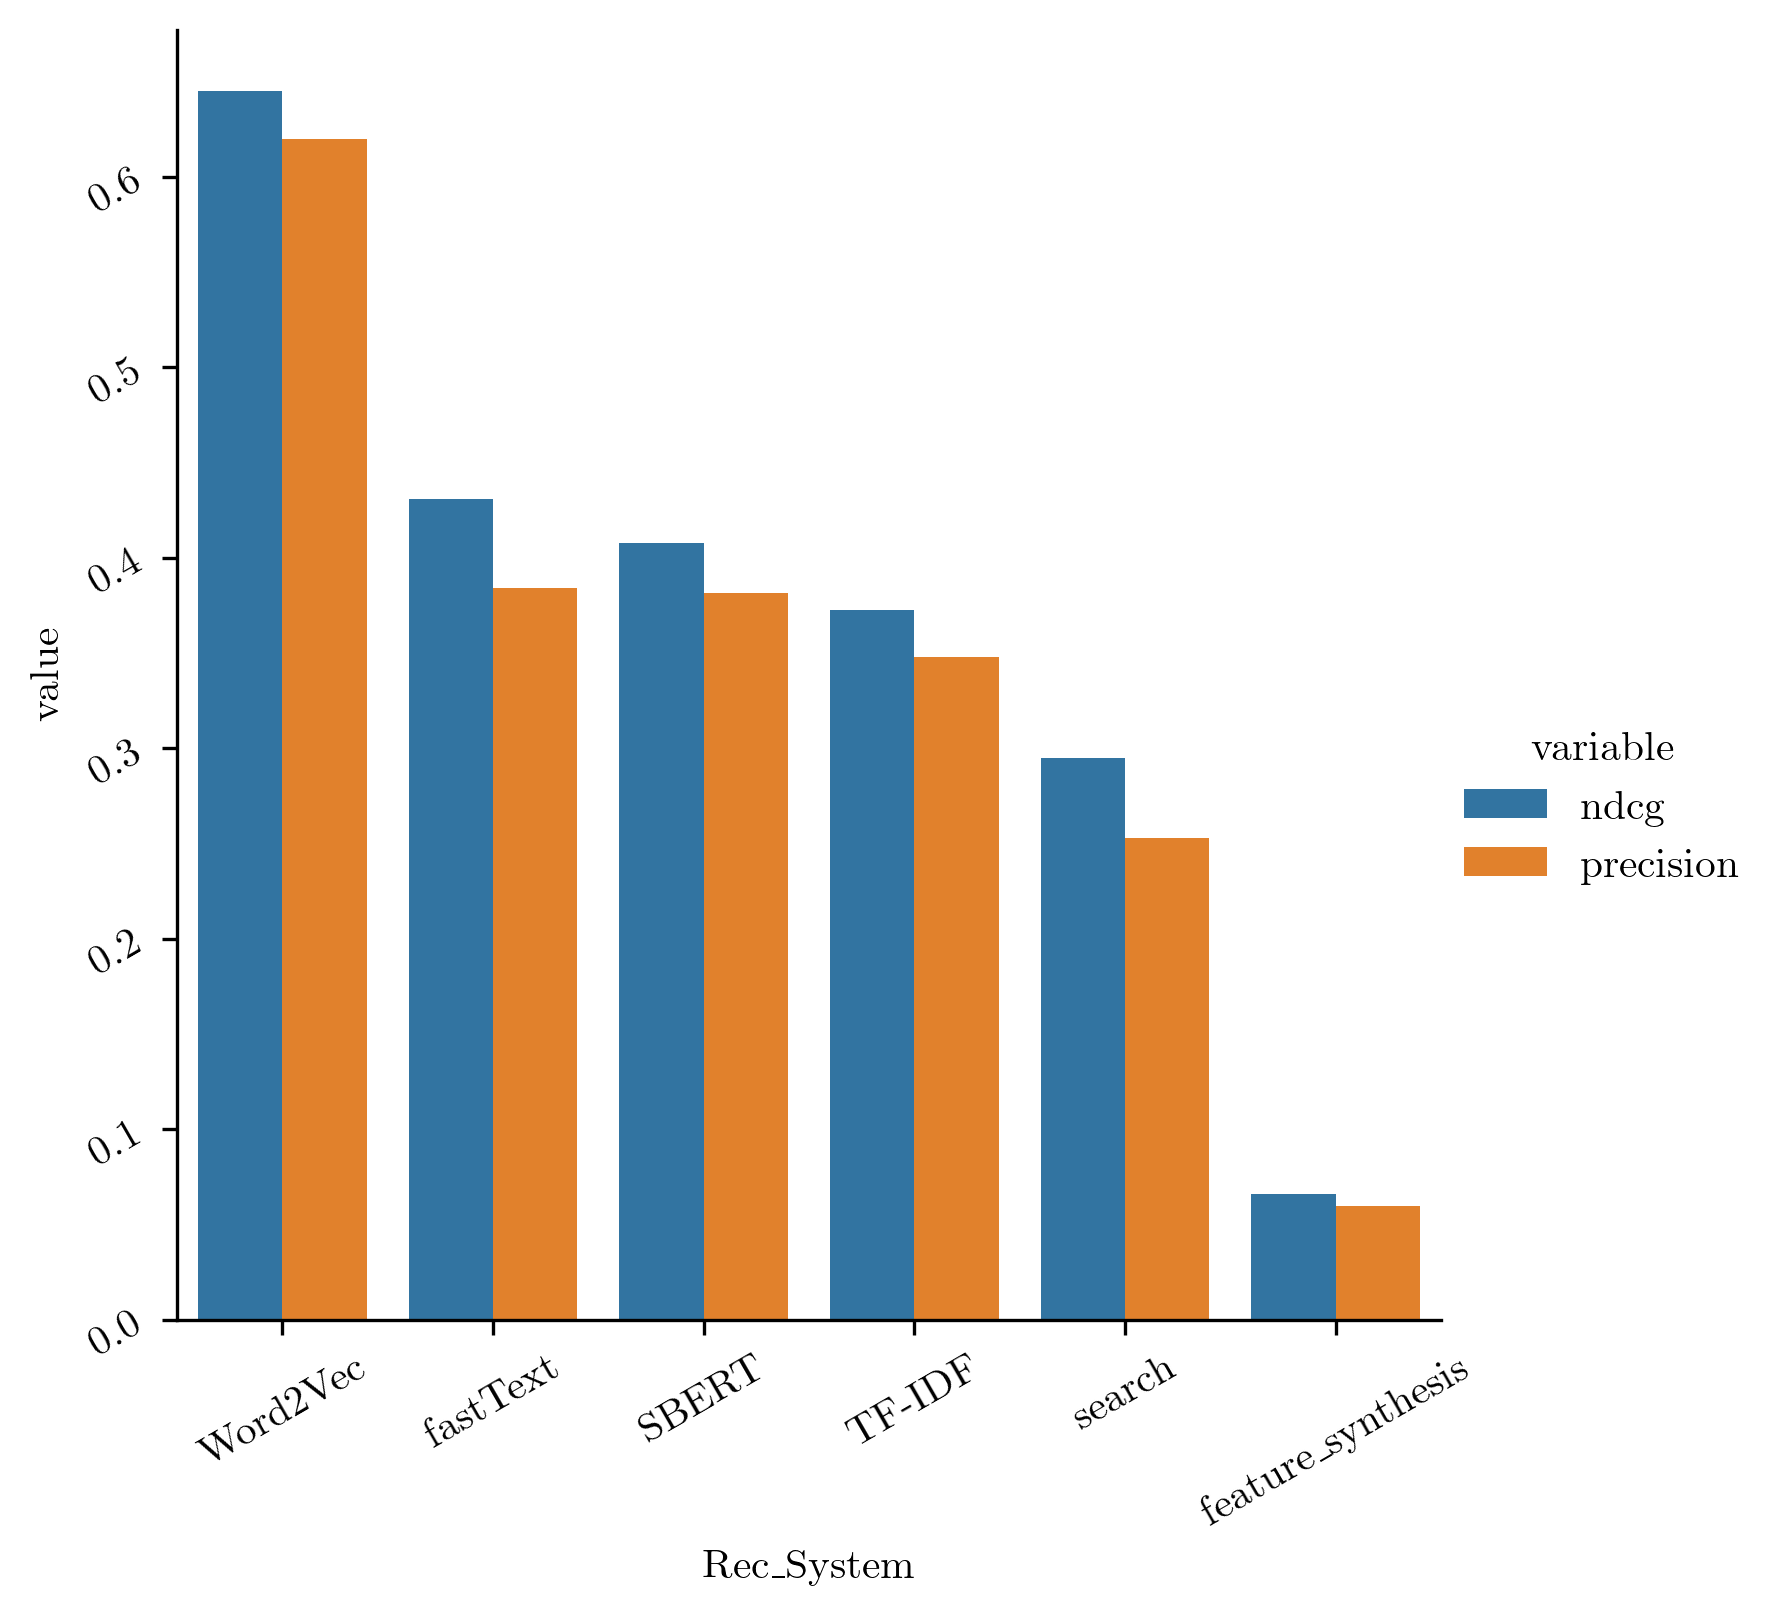

In [17]:
# sorted = metrics.sort_values("ndcg", ascending=False)

sorted_melted = metrics.melt("Rec_System").sort_values("value", ascending=False)

x_colours = [colors[x] for x in sorted_melted["Rec_System"]]


ax = sns.catplot(sorted_melted, x="Rec_System", y="value", hue="variable", kind="bar")
# ax = sns.barplot(sorted, x="Rec_System",y="ndcg", palette=x_colours)
# ax = sns.barplot(sorted, x="Rec_System",y="precision", palette=x_colours)
# ax.set(
#     xlabel="Recommender System",
#     ylabel="Precision / Mean NDCG"
# )
ax.tick_params(rotation=30)

# for bar in ax.patches:
#     height = bar.get_height()

#     ax.text(x=bar.get_x()+(bar.get_width()/2),
#             y=height*1.01,
#             s=f"{height:.5g}",
#             ha="center")


plt.show()

# Runtimes

In [18]:
execution_times = pd.read_csv("./data/execution_times.csv")

In [19]:
execution_times

,system,build_time,rec_time
0,Word2Vec,173.844600,0.018103
1,fastText,680.815330,0.038475
2,SBERT,1941.752200,0.112950
3,feature_synthesis,2845.125800,0.329412
4,TF-IDF,6.365670,0.109551
5,search,0.000035,0.883746


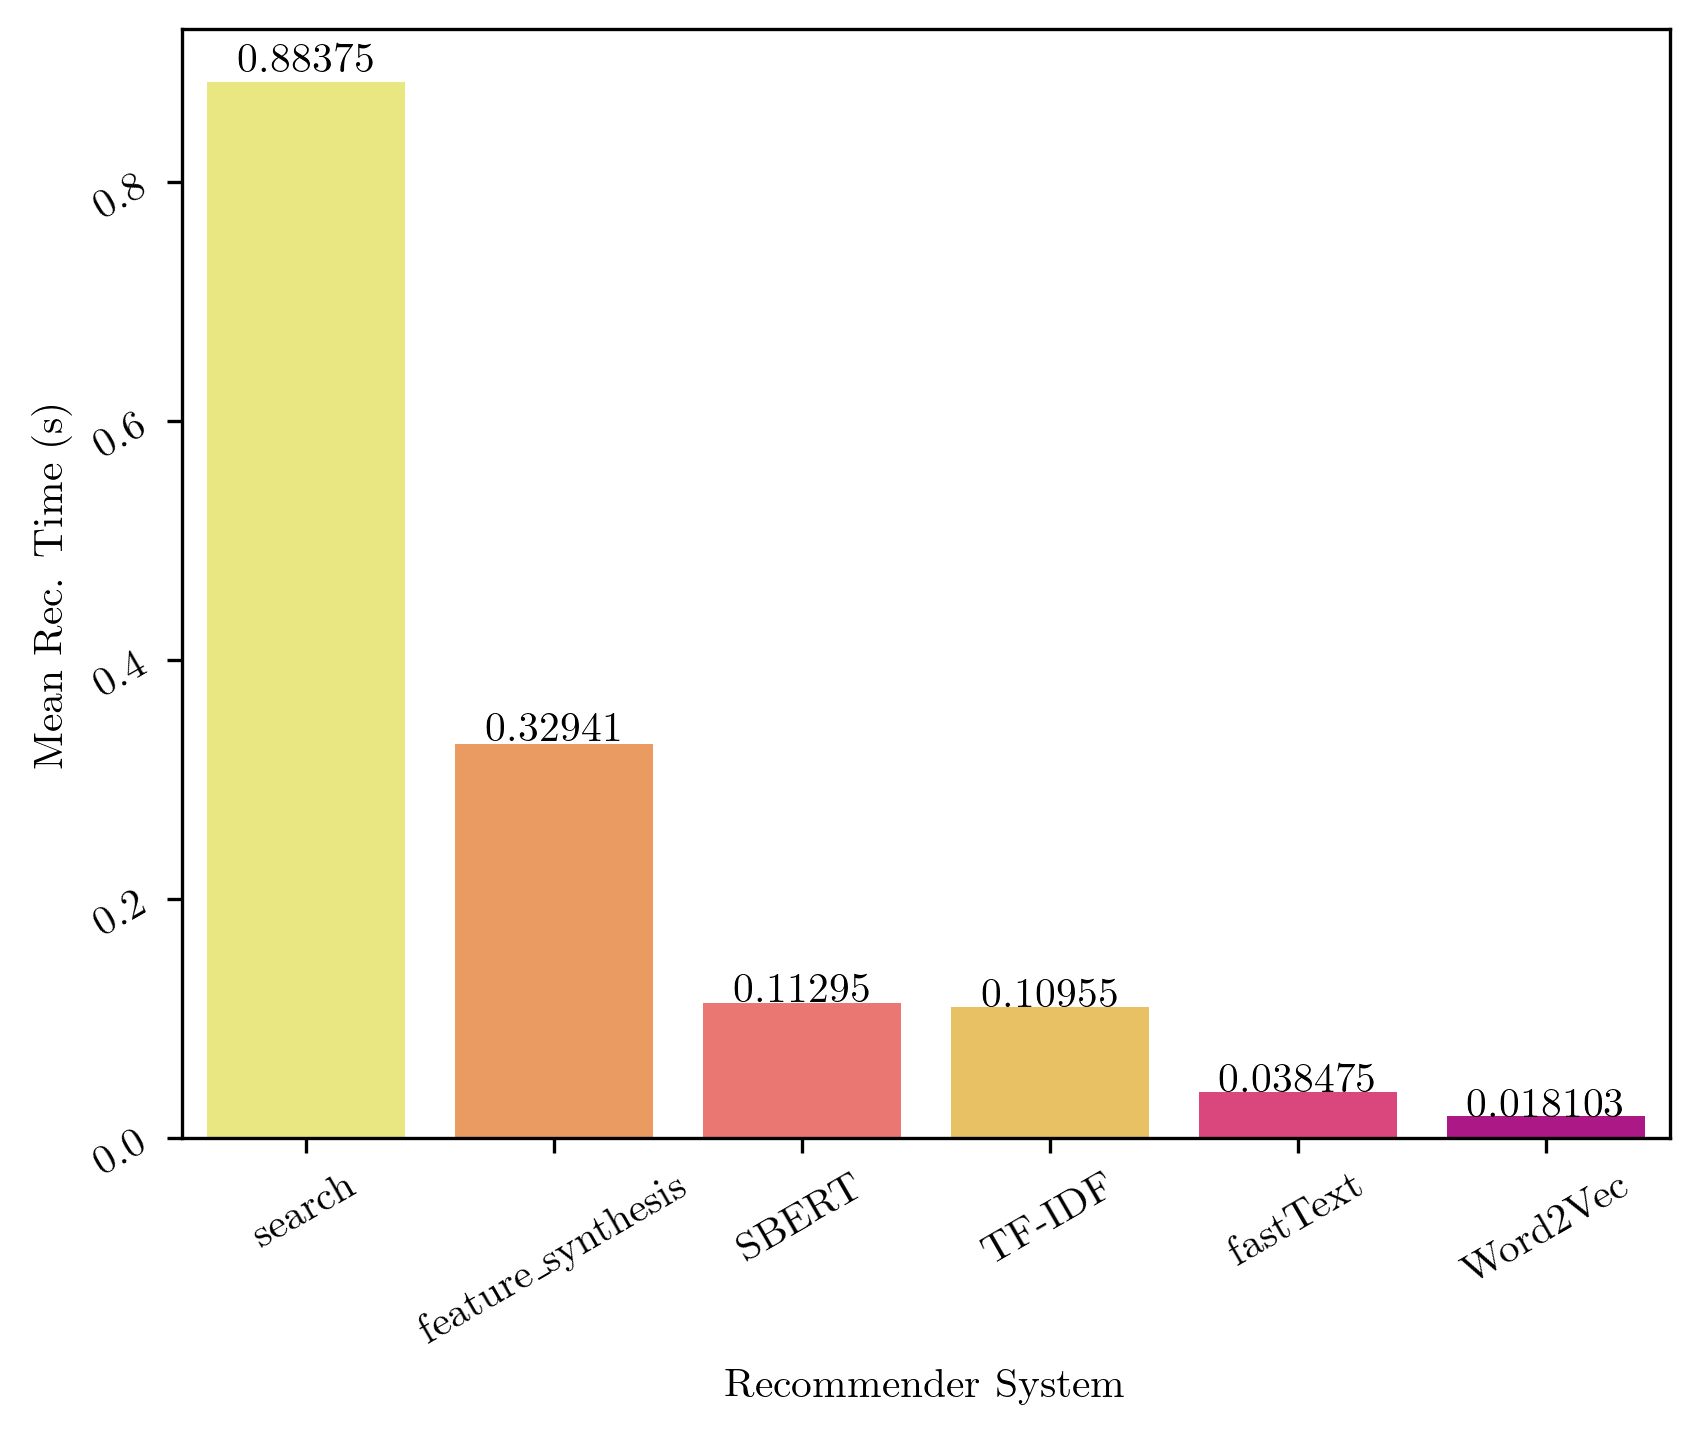

<Figure size 6000x3000 with 0 Axes>

In [20]:
barplotter(
    execution_times, "system", "Recommender System", "rec_time", "Mean Rec. Time (s)"
)

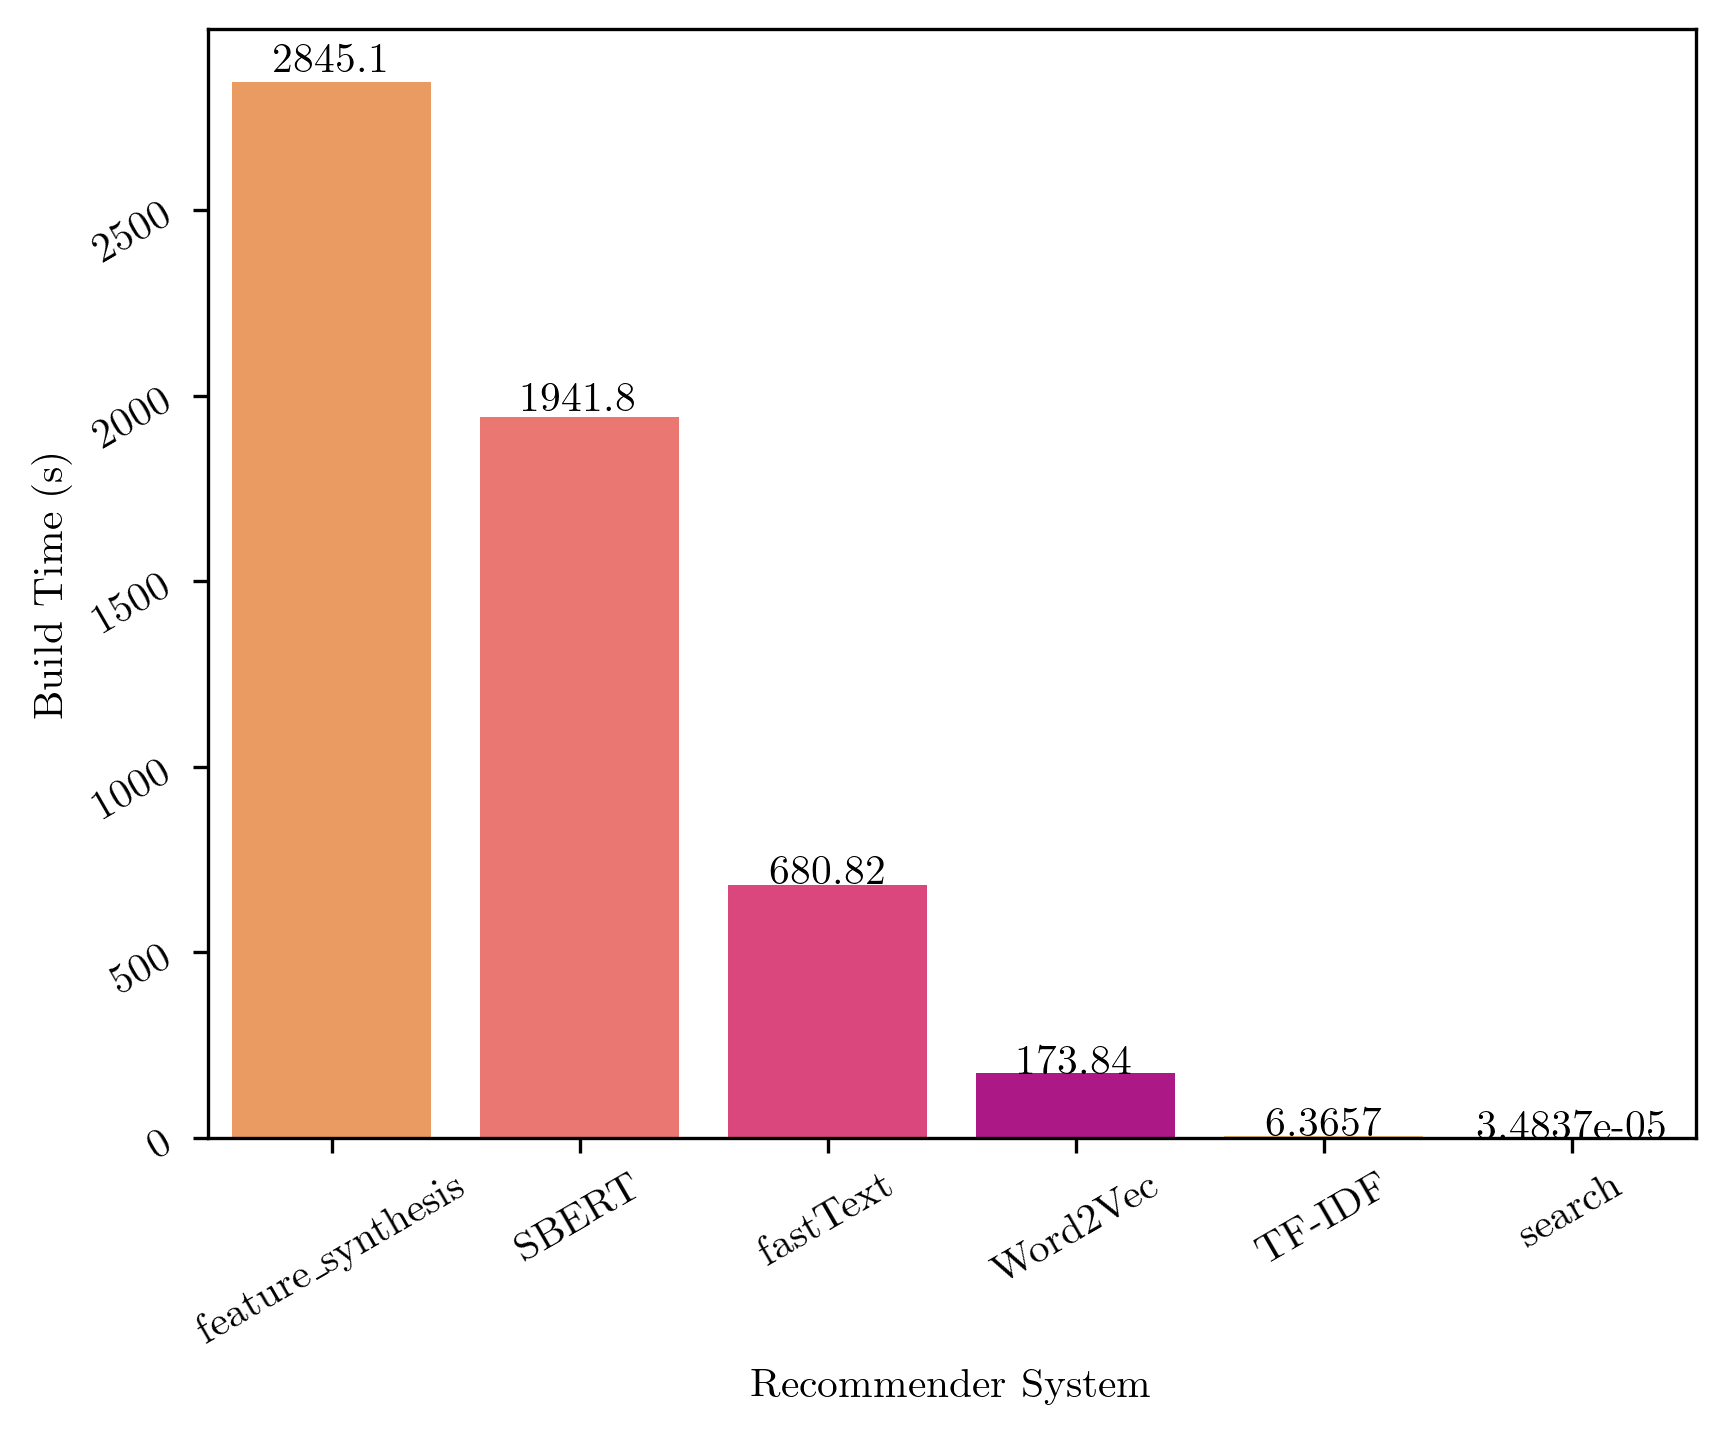

<Figure size 6000x3000 with 0 Axes>

In [21]:
barplotter(
    execution_times, "system", "Recommender System", "build_time", "Build Time (s)"
)